In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from functools import lru_cache

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stasa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from collections import defaultdict

Атрибутный состав данных

* text - Текст твита 
* keyword - Ключевое слово твита
* location - Место отправки твита

**Необходимо предсказать, написан ли твит о реальном происшествии или это фейк, метки классов соответсвенно 1 и 0.**

https://www.kaggle.com/c/nlp-getting-started/overview

# Загрузка данных

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


В данных много пропущенных значений, с ними надо что делать

# Проверка пропущенных значений

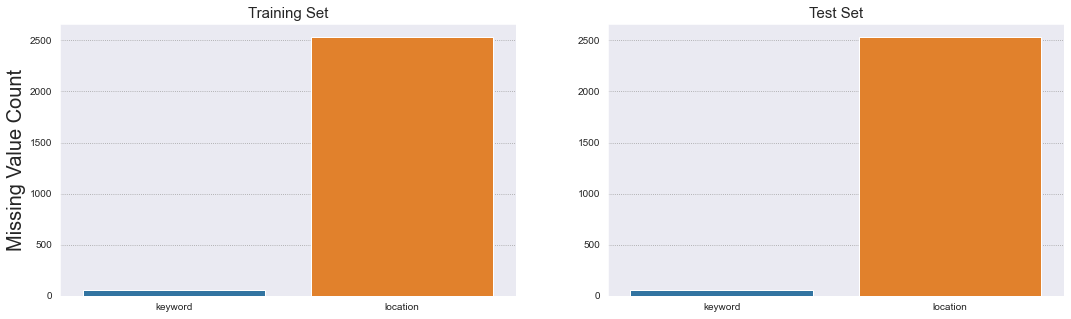

In [5]:
missing_cols = ['keyword', 'location']

fig, ax = plt.subplots(ncols=2, figsize=(18, 5))

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=ax[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=ax[1])

ax[0].set_ylabel('Missing Value Count', size=20)

ax[0].set_title('Training Set', fontsize=15)
ax[1].set_title('Test Set', fontsize=15)

plt.show()

# Баланс целевой величины

Посмотрим на баланс целевой величины

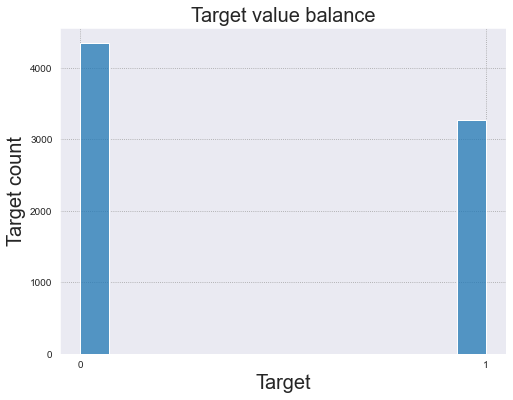

In [6]:
plt.figure(figsize=(8,6))
plt.title('Target value balance',size=20)
sns.histplot(data=df_train, x='target')
plt.xlabel('Target', size=20)
plt.ylabel('Target count', size=20)
plt.xticks([0,1])
plt.show()

В целом баланс хороший, но все таки лучше не использовать accuracy в данной задаче (баланс не 50 на 50). Будем сравнивать алгоритмы по метрике balanced accuracy. У некоторых алгоритмов есть параметр class_weights для несбалансированных данных. Если возможно, будем использовать class_weights = 'balanced'.

# Анализ данных

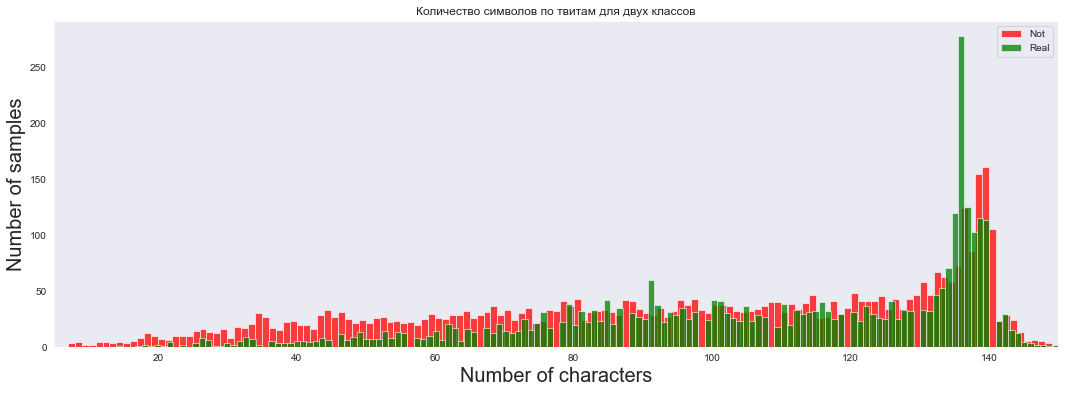

In [7]:
plt.figure(figsize=(18,6))
plt.title('Количество символов по твитам для двух классов')
bins = 150
df_train['len'] = df_train['text'].apply(len)
sns.histplot(df_train[df_train['target'] == 0]['len'], bins=bins, label='Not', color='red')
sns.histplot(df_train[df_train['target'] == 1]['len'], bins=bins, label='Real', color='green')
plt.xlabel('Number of characters', size=20)
plt.ylabel('Number of samples', size=20)
plt.legend(loc='upper right')
plt.xlim(5,150)
plt.grid()
plt.show()
df_train.drop(columns=['len'], inplace=True)

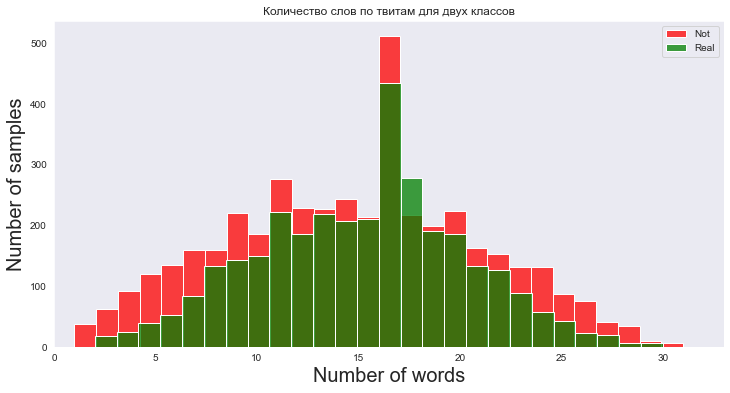

In [8]:
plt.figure(figsize=(12,6))
plt.title('Количество слов по твитам для двух классов')
df_train['len'] = df_train['text'].apply(lambda x: len(x.split()))
sns.histplot(df_train[df_train['target'] == 0]['len'], label='Not', color='red')
sns.histplot(df_train[df_train['target'] == 1]['len'], label='Real', color='green')
plt.xlabel('Number of words', size=20)
plt.ylabel('Number of samples', size=20)
plt.legend(loc='upper right')
plt.xlim(0,33)
plt.grid()
plt.show()
df_train.drop(columns=['len'], inplace=True)

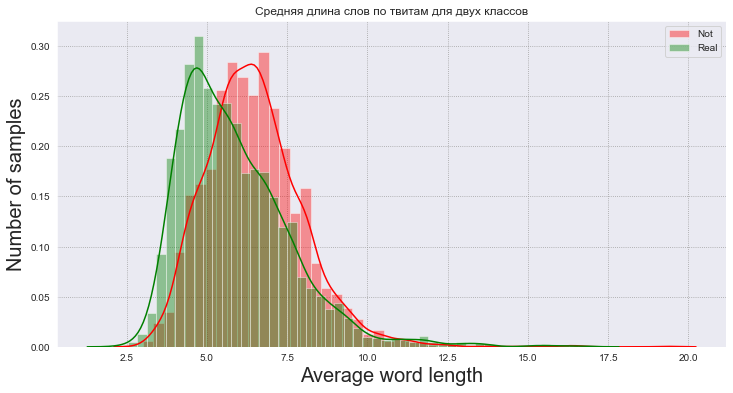

In [9]:
plt.figure(figsize=(12,6))
plt.title('Средняя длина слов по твитам для двух классов')
word = df_train[df_train['target'] == 1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), color='red', label='Not')
word = df_train[df_train['target'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), color='green', label='Real')

plt.xlabel('Average word length', size=20)
plt.ylabel('Number of samples', size=20)
plt.legend(loc='upper right')
plt.show()

# Работа с пропущенными значениями

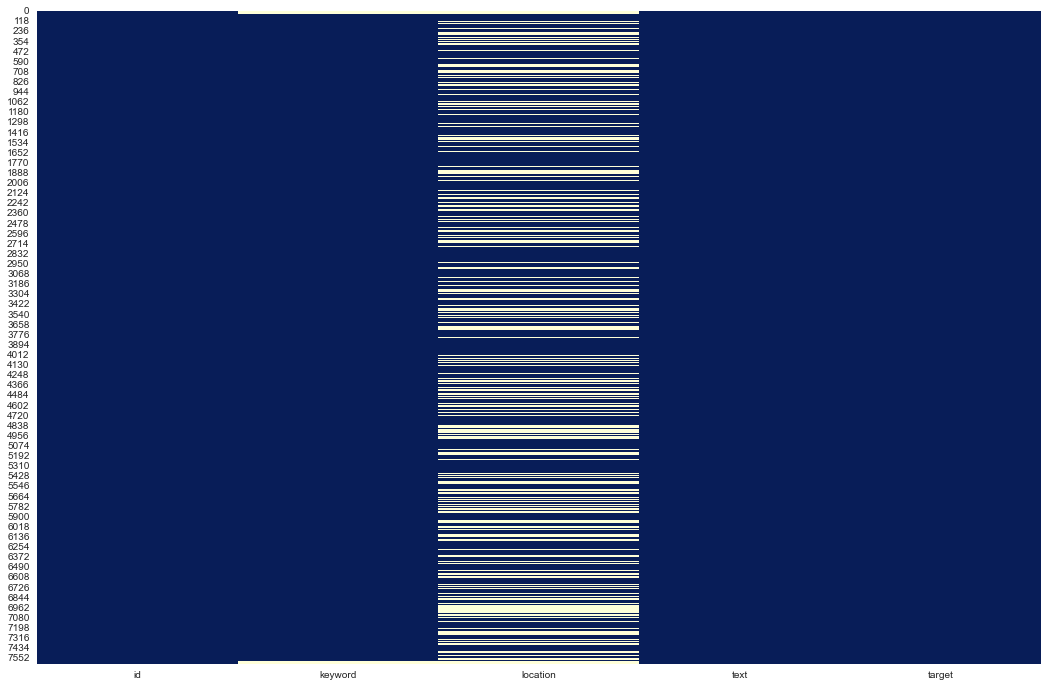

In [10]:
plt.figure(figsize=(18,12))
sns.heatmap(df_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [11]:
df_train.fillna('Other', inplace=True)
df_train.head()

,id,keyword,location,text,target
0,1,Other,Other,Our Deeds are the Reason of this #earthquake M...,1
1,4,Other,Other,Forest fire near La Ronge Sask. Canada,1
2,5,Other,Other,All residents asked to 'shelter in place' are ...,1
3,6,Other,Other,"13,000 people receive #wildfires evacuation or...",1
4,7,Other,Other,Just got sent this photo from Ruby #Alaska as ...,1


# Анализ ключевых слов

In [12]:
df_train.groupby('keyword').text.count().sort_values(ascending=False).head(30)

keyword
Other          61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
outbreak       40
siren          40
twister        40
windstorm      40
collided       40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
explosion      39
whirlwind      39
earthquake     39
derailment     39
wreckage       39
collision      39
flames         39
wrecked        39
ambulance      38
Name: text, dtype: int64

Видим, что из-за ошибки часто встречается символ %20 - это пробел, его необходимо почистить

In [13]:
df_train['keyword'] = df_train['keyword'].apply(lambda x: x.replace('%20', ' ') if x == x else x)
df_test['keyword'] = df_test['keyword'].apply(lambda x: x.replace('%20', ' ') if x == x else x)

Посмотрим, как сильно ключевые слова влияют на таргет

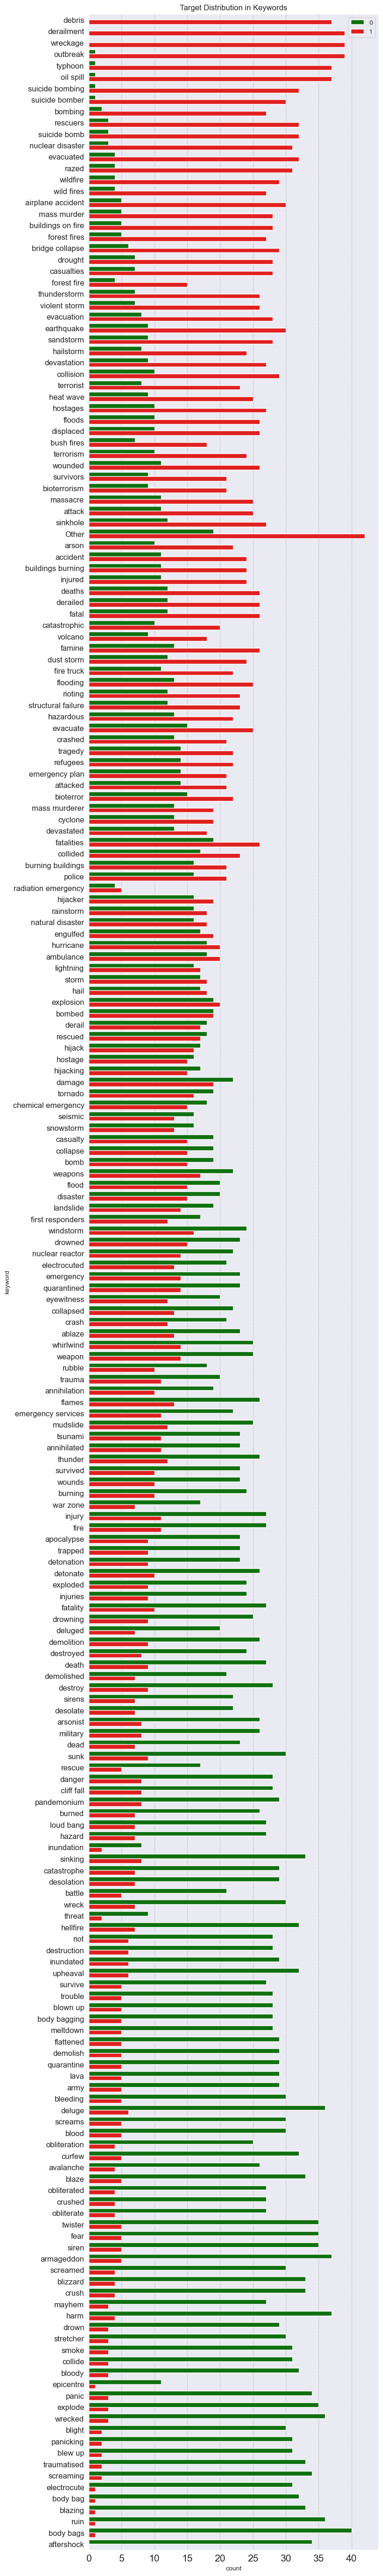

In [15]:
fig = plt.figure(figsize=(8, 72), dpi=100)
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'],
             palette=['green','red'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Видим, что их влияние неллзя недооценить, их обязательно стоит использовать для предсказаний

Посмотрим, как сильно n-граммы влияют на таргет. Предварительно необходимо почистить текст от мусора

In [16]:
class Text_preproc():
    def __init__(self, language):
        if language == 'english':
            self.bad_reg = re.compile('[^a-z\s\d #]')
            self.stopwords = set(stopwords.words('english'))
            eng_lemmatizer = WordNetLemmatizer()
            @lru_cache(maxsize=10 ** 6)
            def lru_eng_lemmatizer(word):
                return eng_lemmatizer.lemmatize(word)
            self.lemmatizer = lru_eng_lemmatizer
        else:
             raise NotImplementedError('Not supported language')


    def remove_URL(self, text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)


    def remove_html(self, text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)


    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

            
    def __call__(self, text):
        text = self.remove_URL(text)
        text = self.remove_html(text)
        text = self.remove_emoji(text)
        text = text.lower()
        text = re.sub(self.bad_reg, ' ', text)
        text = re.sub('\n|\t', ' ', text)
        text = re.sub(' +', ' ', text)
        lemmas = [self.lemmatizer(word) for word in text.split()]
        lemmas = [word for word in lemmas if word not in self.stopwords]
        
        return ' '.join(lemmas) 

In [17]:
preprocessor = Text_preproc('english')

df_train['clear_text'] = df_train['text'].apply(preprocessor)
df_test['clear_text'] = df_test['text'].apply(preprocessor)

df_train.head()

,id,keyword,location,text,target,clear_text
0,1,Other,Other,Our Deeds are the Reason of this #earthquake M...,1,deed reason #earthquake may allah forgive u
1,4,Other,Other,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,Other,Other,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,Other,Other,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive #wildfires evacuation or...
4,7,Other,Other,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


In [18]:
def create_corpus(df, target):
    corpus=[]
    
    for x in df[df.target == target]['clear_text']:
        for i in x.split():
            corpus.append(i)
    return corpus

In [19]:
corpus0 = create_corpus(df_train, 0)
corpus1 = create_corpus(df_train, 1)

In [20]:
corpus1[:5]

['deed', 'reason', '#earthquake', 'may', 'allah']

In [21]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text if token != '' if token not in preprocessor.stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [22]:
N = 20

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)


for word in generate_ngrams(corpus1):
    disaster_unigrams[word] += 1

for word in generate_ngrams(corpus0):
    nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)


for word in generate_ngrams(corpus1, n_gram=2):
    disaster_bigrams[word] += 1


for word in generate_ngrams(corpus0, n_gram=2):
    nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)


for word in generate_ngrams(corpus1, n_gram=3):
    disaster_trigrams[word] += 1


for word in generate_ngrams(corpus0, n_gram=3):
    nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

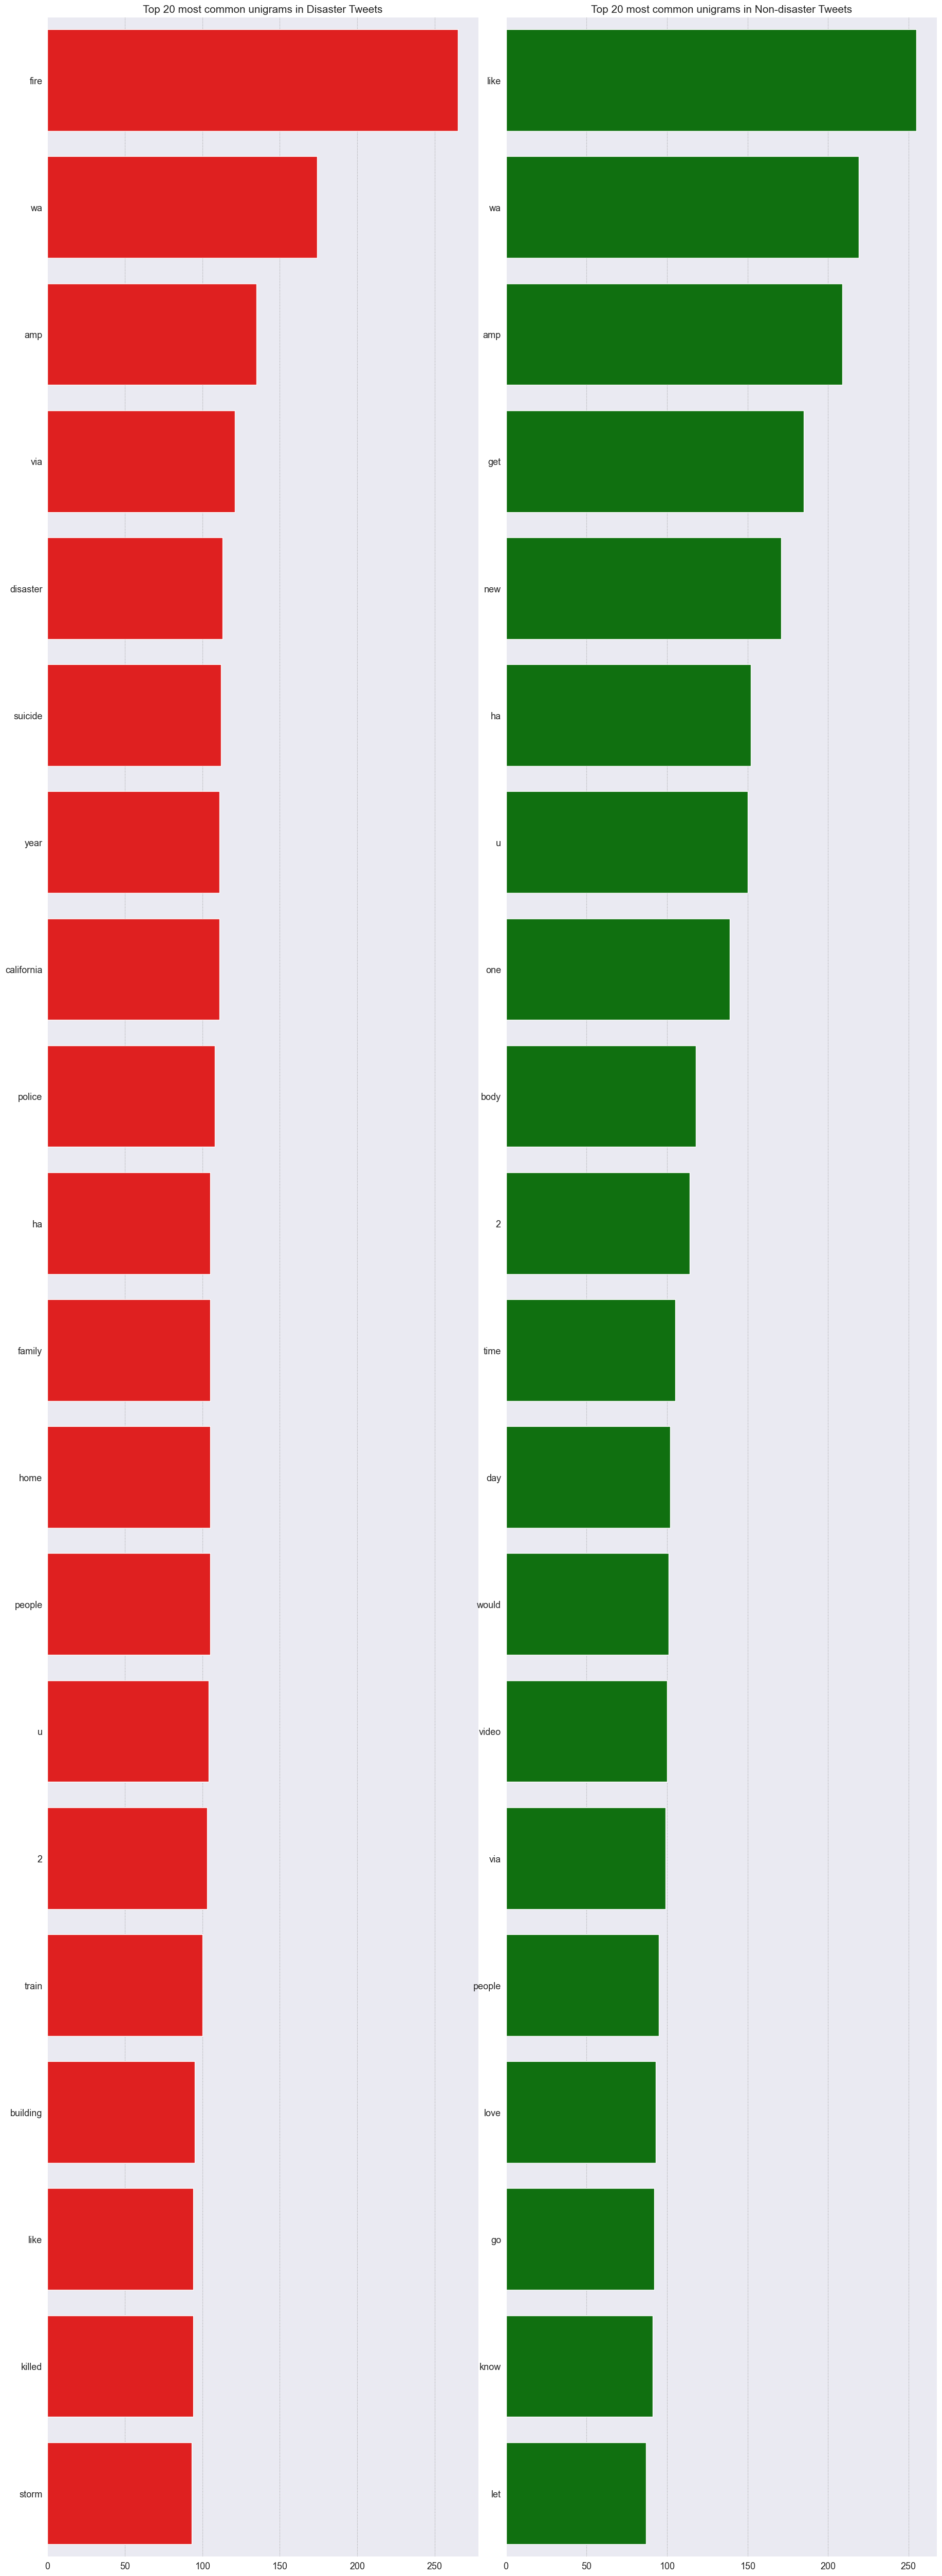

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

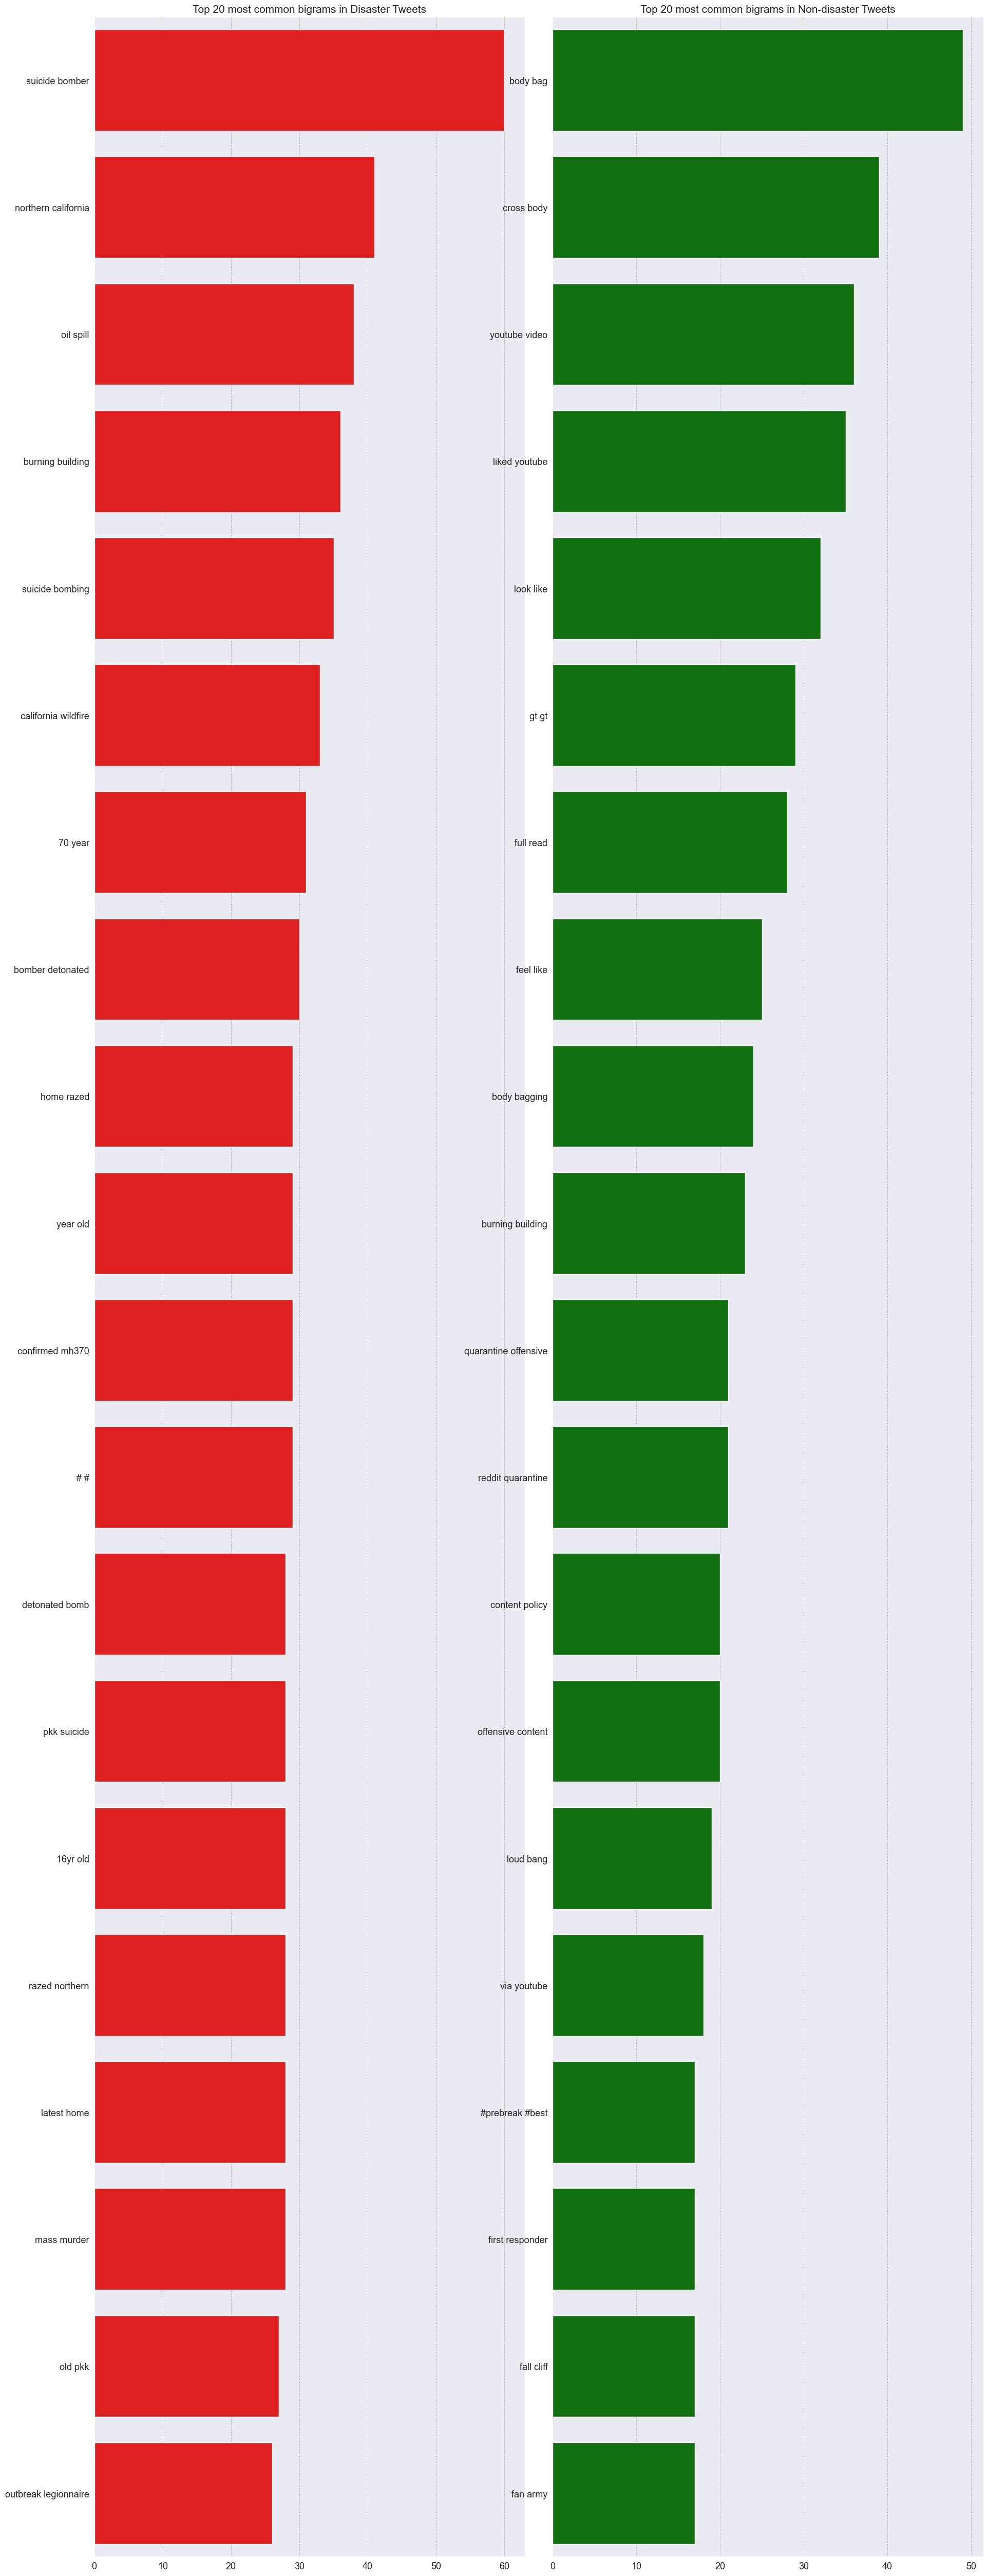

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

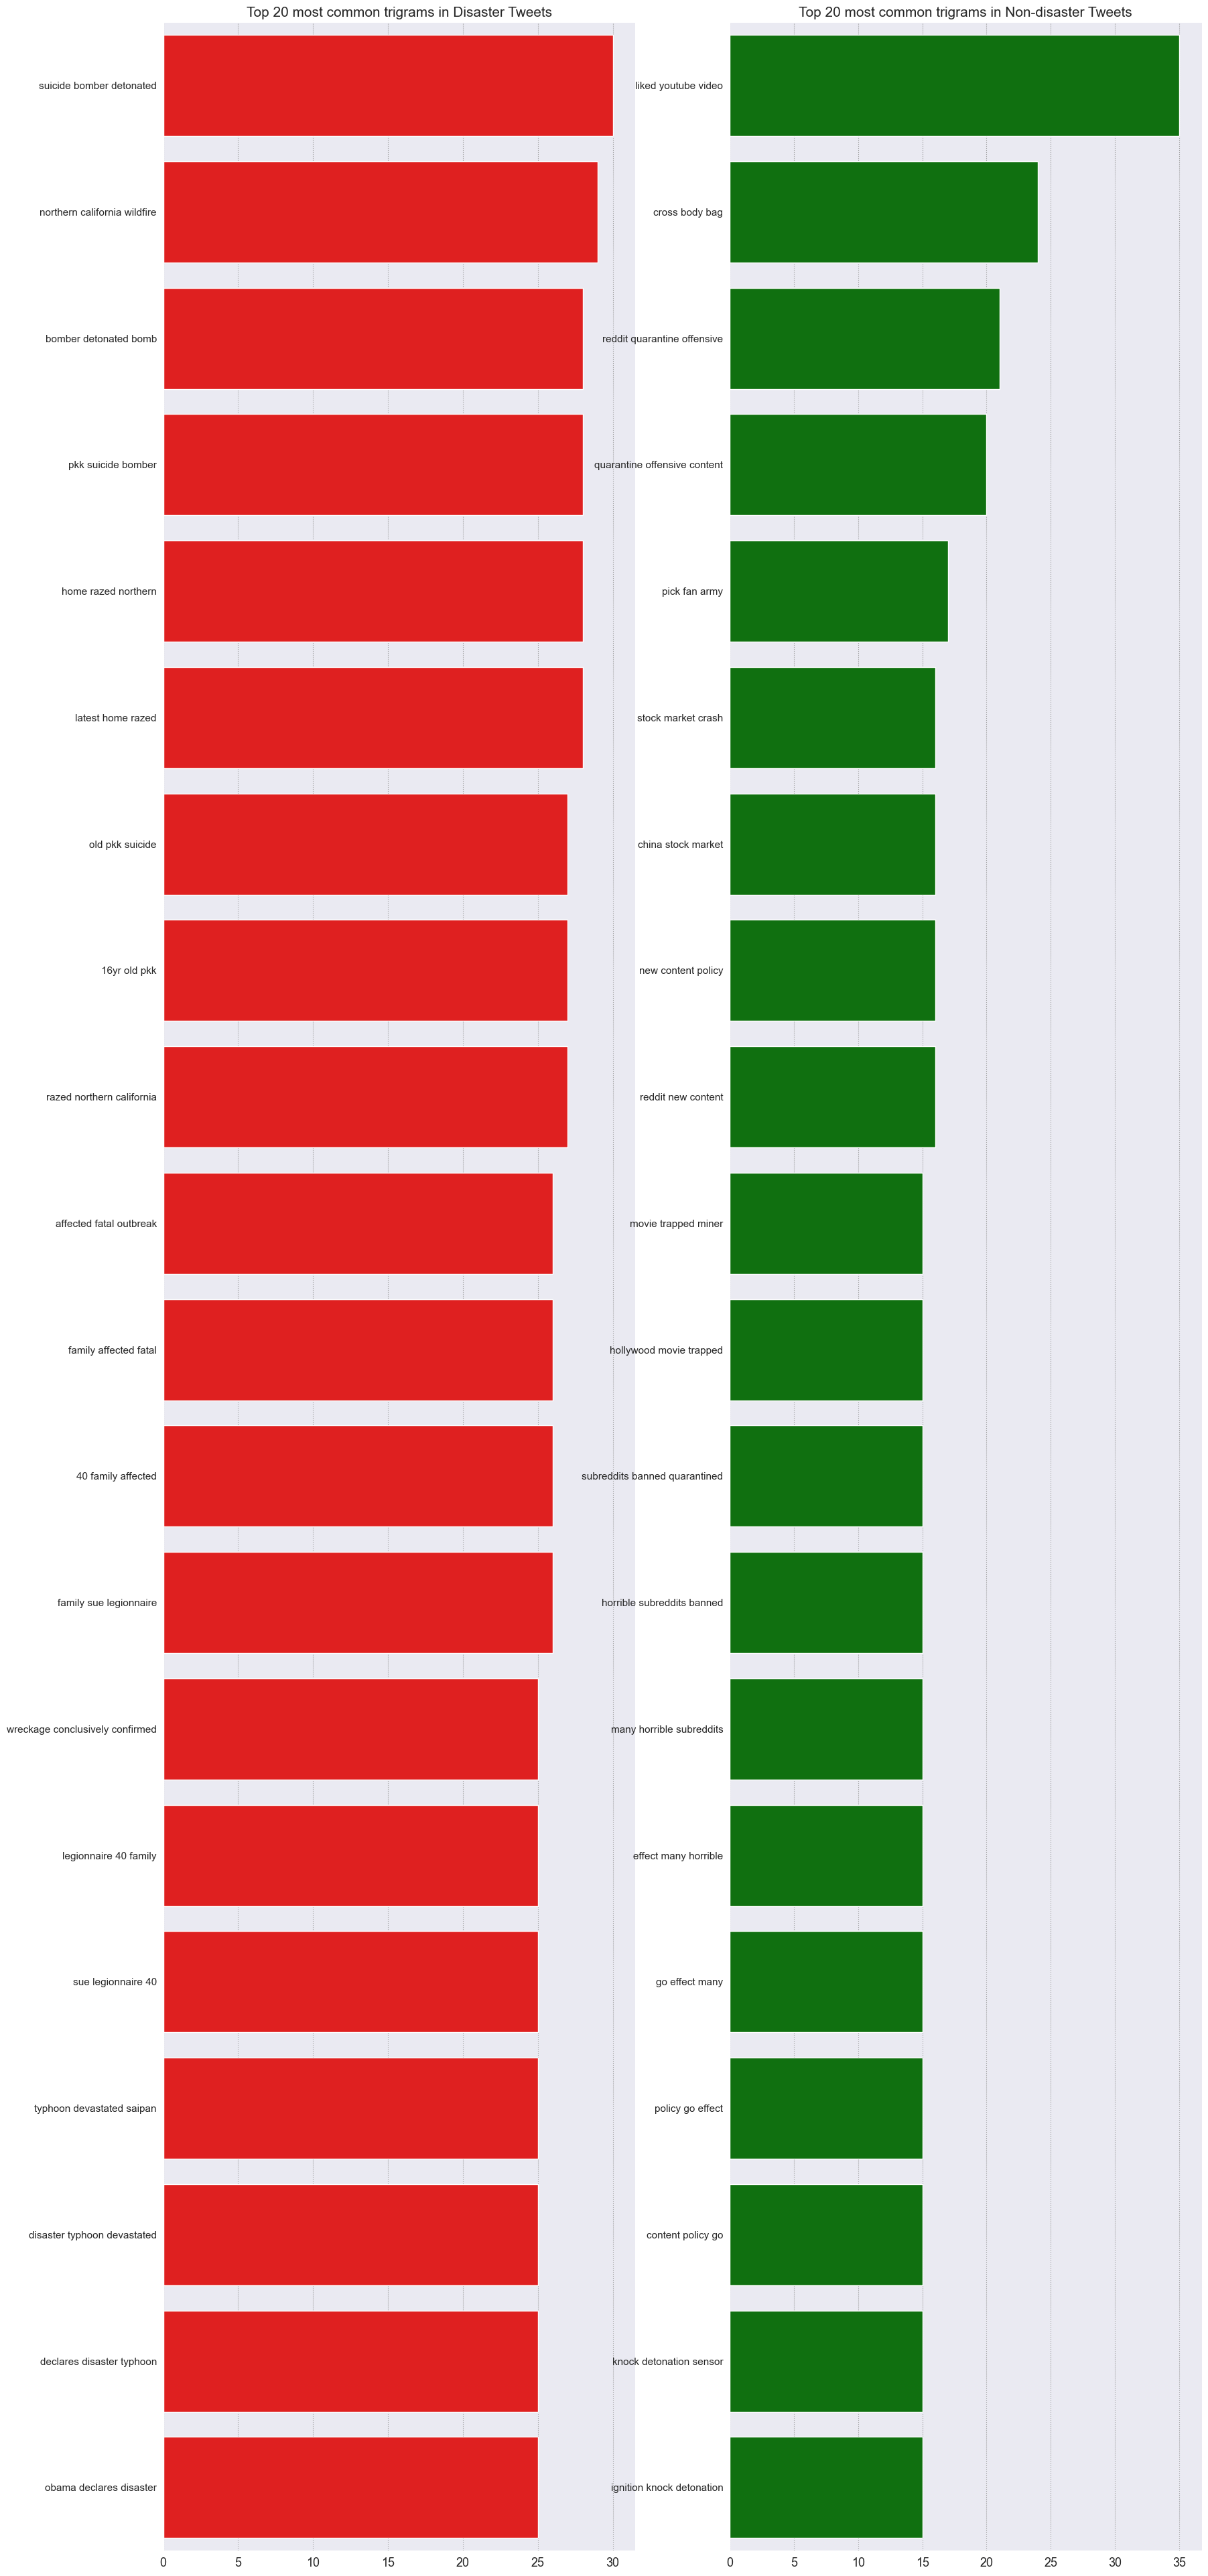

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()